# Polynomial Regression for Stellar Luminosity

## 1. Imports and Dataset Definition

We define the dataset directly in the notebook, as required. The goal is to model stellar luminosity as a function of stellar mass and temperature, including nonlinear and interaction effects.

In [1]:
import numpy as np
import matplotlib.pyplot as plt


In [2]:
# Dataset
M = np.array([0.6, 0.8, 1.0, 1.2, 1.4, 1.6, 1.8, 2.0, 2.2, 2.4])
T = np.array([3800, 4400, 5800, 6400, 6900, 7400, 7900, 8300, 8800, 9200])
L = np.array([0.15, 0.35, 1.00, 2.30, 4.10, 7.00, 11.2, 17.5, 25.0, 35.0])

m = len(L)

## 2. Dataset Visualization (Mandatory)

Before modeling, it is important to visually inspect the data. We plot luminosity versus mass, encoding temperature as color. This allows us to identify nonlinear trends and interactions between mass and temperature.

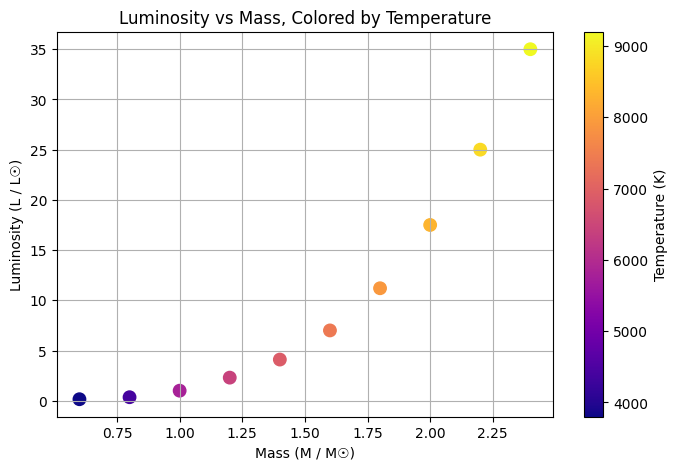

: 

In [ ]:
plt.figure(figsize=(8, 5))
scatter = plt.scatter(M, L, c=T, cmap='plasma', s=80)
plt.colorbar(scatter, label='Temperature (K)')
plt.xlabel('Mass (M / M☉)')
plt.ylabel('Luminosity (L / L☉)')
plt.title('Luminosity vs Mass, Colored by Temperature')
plt.grid(True)
plt.show()
